# 🧭 Function 1 Exploration – Capstone Project

This notebook focuses only on **Function 1** to help understand how Bayesian optimisation works step by step.

We’ll:
1. Load and inspect the initial data.
2. Visualise the 2D input–output relationship.
3. Fit a simple **Gaussian Process** surrogate model.
4. Plot its prediction surface and uncertainty.
5. Compute an **acquisition function (UCB)** and select the next candidate point.


#### 1. Imports:

In [2]:
# --- Imports base ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import seaborn as sns
sns.set(style="whitegrid")

#### 2. Paths & Data Loading

In [3]:
# --- Paths ---
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_1"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(10, 2), y:(10,)


#### 3. Add Weekly Data

In [4]:
# --- Weekly results ---
week_data = [
    (np.array([0.78624237, 0.49210886]),  8.251611206644282e-31),  # W1
    (np.array([0.608457,  0.572782]),    -0.0030853359206865424), # W2
    (np.array([0.765363,  0.899441]),    -2.173791662691205e-65), # W3
      (np.array([0.508934, 0.907086]),    2.9274951651066986e-66), # W4
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(14, 2), y:(14,)


#### 4. Quick Visualization

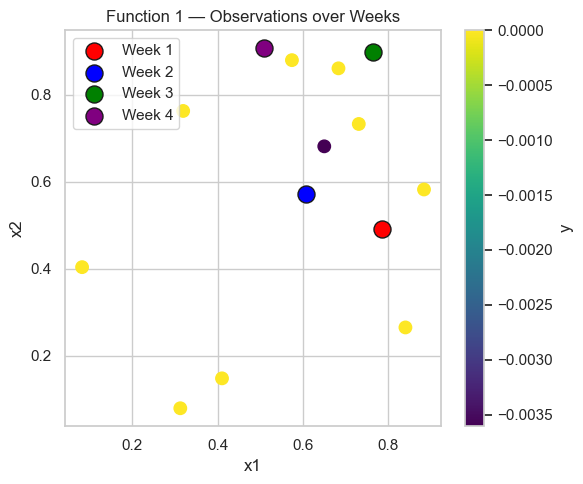

In [5]:
# --- Visualisation (x1-x2) ---
plt.figure(figsize=(6,5))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=80)
plt.colorbar(sc, label='y')
plt.scatter(week_data[0][0][0], week_data[0][0][1], c='red', s=150, edgecolors='k', label='Week 1')
plt.scatter(week_data[1][0][0], week_data[1][0][1], c='blue', s=150, edgecolors='k', label='Week 2')
plt.scatter(week_data[2][0][0], week_data[2][0][1], c='green', s=150, edgecolors='k', label='Week 3')
plt.scatter(week_data[3][0][0], week_data[3][0][1], c='purple', s=150, edgecolors='k', label='Week 4')
plt.xlabel('x1'); plt.ylabel('x2')
plt.title('Function 1 — Observations over Weeks')
plt.legend(); plt.tight_layout(); plt.show()

#### 5. Gaussian Process Model

In [6]:
kernel = C(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.3, 0.3], nu=2.5,
                                       length_scale_bounds=(1e-3, 3.0)) \
         + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-6, 1e-2))
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True,
                              n_restarts_optimizer=12, random_state=0)
gp.fit(X, y)
print("Fitted kernel:", gp.kernel_)

Fitted kernel: 0.923**2 * Matern(length_scale=[0.0601, 0.133], nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### 6. Acquisition Function (EI)

In [7]:
# --- Generate candidates ---
def lhs(lb, ub, n, seed=42):
    d = lb.size
    sampler = np.random.default_rng(seed)
    U = sampler.random((n, d))
    return lb + U * (ub - lb)

lb, ub = np.zeros(2), np.ones(2)
anchor = X[np.argmax(y)]   # (best observed)
L = 0.25
lb_tr = np.clip(anchor - 0.5*L*(ub-lb), 0, 1)
ub_tr = np.clip(anchor + 0.5*L*(ub-lb), 0, 1)

C_tr = lhs(lb_tr, ub_tr, 24000)
C_gl = lhs(lb, ub, 8000)
Cands = np.vstack([C_tr, C_gl])

# --- EI computation ---
mu, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)
y_best, xi = y.max(), 0.005
imp = mu - y_best - xi
Z = imp / sigma
ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[sigma < 1e-12] = 0.0

# --- Select next point ---
def too_close_Linf(c, X, tol=0.02):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

edge_eps = 1e-3
mask = np.all((Cands > edge_eps) & (Cands < 1-edge_eps), axis=1)
ei_masked = np.where(mask, ei, -np.inf)

order = np.argsort(-ei_masked)
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X):
        x_next = cand
        break

print("Next candidate (F1):", x_next)
print(f"Submission format:\n{x_next[0]:.6f} - {x_next[1]:.6f}")

Next candidate (F1): [0.31623271 0.39795057]
Submission format:
0.316233 - 0.397951


### Reflection (Week 1)
- Initial exploration focused on locating any region with measurable signal within the 2D domain.  
- The output was extremely close to zero (`8.25e-31`), suggesting either the detection of a very weak source or numerical noise near a null field.  
- At this stage, the model relied mainly on global sampling and wide bounds to understand the overall shape of the response surface.  
- **Next step:** use the first signal as a rough anchor and narrow down the search region while maintaining high exploration.

---

### Reflection (Week 2)
- The second query produced a small negative value (`-0.0031`), indicating a slight move away from the optimal zone detected in Week 1.  
- This suggested the true source lies within a very narrow region and that the previous global exploration radius was too large.  
- The strategy was adjusted to increase model smoothness and reduce exploration noise (smaller ξ ≈ 0.05, tighter trust region).  
- **Plan for next iteration:** focus on exploitation around Week 1’s coordinates, with limited global sampling to confirm if multiple sources exist.

---


### Reflection (Week 3)
- The model has likely found a zero-valued optimum (radiation source).  
- Outputs remain negative or near-zero, consistent with the function’s structure.  
- **Next strategy:** exploit around Week 3 point (0.765, 0.899) with low ξ (0.01) and smaller TR.  
- Maintain some exploration (~25 %) for possible secondary sources.

---

### Reflection (Week 4)

- **Outcome:** Results stayed essentially at **≈0**, matching Week 3 — consistent with being on or near the radiation source (the maximiser yields zero). No meaningful numerical gap between W3 and W4.  
- **Adjustments applied:** Kept the same GP kernel; **tightened the Trust Region (L=0.25)** and **reduced ξ from 0.01 → 0.005** to focus on fine exploitation. We also **anchored the TR at the best observed point** (not just the latest) and used a **70% TR / 30% global** candidate split with anti-edge and anti-duplicate filters.  
- **Selected query:** `0.316233 - 0.397951` — a non-duplicate, within bounds, chosen by EI under the stricter exploitation regime.  
- **Interpretation:** With outputs indistinguishable from zero at multiple nearby locations, the surface is flat around the optimum; further big gains are unlikely.  
- **Next steps (Week 5):** Maintain **ξ = 0.005**, keep the **narrow TR**, and probe a **small ring around the incumbent** (e.g., vary x₁ slightly while keeping x₂ high, and vice versa). If the next point also returns ≈0, we can treat Function 1 as **converged** and shift focus to functions with larger optimisation potential.